$$
\newcommand{\mat}[1]{\boldsymbol {#1}}
\newcommand{\mattr}[1]{\boldsymbol {#1}^\top}
\newcommand{\matinv}[1]{\boldsymbol {#1}^{-1}}
\newcommand{\vec}[1]{\boldsymbol {#1}}
\newcommand{\vectr}[1]{\boldsymbol {#1}^\top}
\newcommand{\rvar}[1]{\mathrm {#1}}
\newcommand{\rvec}[1]{\boldsymbol{\mathrm{#1}}}
\newcommand{\diag}{\mathop{\mathrm {diag}}}
\newcommand{\set}[1]{\mathbb {#1}}
\newcommand{\norm}[1]{\left\lVert#1\right\rVert}
\newcommand{\pderiv}[2]{\frac{\partial #1}{\partial #2}}
\newcommand{\bm}[1]{{\bf #1}}
\newcommand{\bb}[1]{\bm{\mathrm{#1}}}
$$

# Part 3: Generative Adversarial Networks
<a id=part3></a>

In this part we will implement and train a generative adversarial network and apply it to the task of image generation.

In [1]:
import unittest
import os
import sys
import pathlib
import urllib
import shutil
import re
import zipfile

import numpy as np
import torch
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

test = unittest.TestCase()
plt.rcParams.update({'font.size': 12})
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


### Obtaining the dataset
<a id=part3_1></a>

We'll use the same data as in Part 2.

But again, you can use a custom dataset, by editing the `PART3_CUSTOM_DATA_URL` variable in `hw4/answers.py`.

In [2]:
import cs236781.plot as plot
import cs236781.download
from hw4.answers import PART3_CUSTOM_DATA_URL as CUSTOM_DATA_URL

DATA_DIR = pathlib.Path.home().joinpath('.pytorch-datasets')
if CUSTOM_DATA_URL is None:
    DATA_URL = 'http://vis-www.cs.umass.edu/lfw/lfw-bush.zip'
else:
    DATA_URL = CUSTOM_DATA_URL

_, dataset_dir = cs236781.download.download_data(out_path=DATA_DIR, url=DATA_URL, extract=True, force=False)

File /home/assaflovton/.pytorch-datasets/lfw-bush.zip exists, skipping download.
Extracting /home/assaflovton/.pytorch-datasets/lfw-bush.zip...
Extracted 531 to /home/assaflovton/.pytorch-datasets/lfw/George_W_Bush


Create a `Dataset` object that will load the extraced images:

In [3]:
import torchvision.transforms as T
from torchvision.datasets import ImageFolder

im_size = 64
tf = T.Compose([
    # Resize to constant spatial dimensions
    T.Resize((im_size, im_size)),
    # PIL.Image -> torch.Tensor
    T.ToTensor(),
    # Dynamic range [0,1] -> [-1, 1]
    T.Normalize(mean=(.5,.5,.5), std=(.5,.5,.5)),
])

ds_gwb = ImageFolder(os.path.dirname(dataset_dir), tf)

OK, let's see what we got. You can run the following block multiple times to display a random subset of images from the dataset.

Found 530 images in dataset folder.


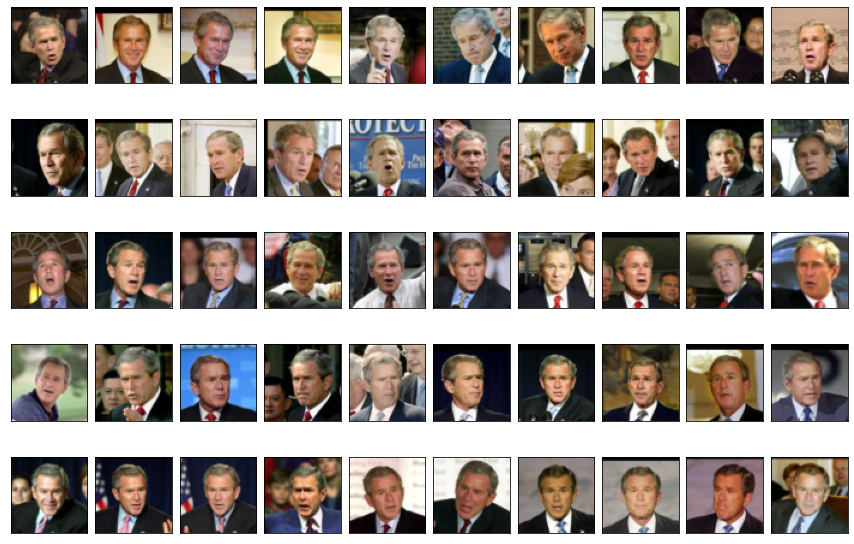

In [4]:
_ = plot.dataset_first_n(ds_gwb, 50, figsize=(15,10), nrows=5)
print(f'Found {len(ds_gwb)} images in dataset folder.')

In [5]:
x0, y0 = ds_gwb[0]
x0 = x0.unsqueeze(0).to(device)
print(x0.shape)

test.assertSequenceEqual(x0.shape, (1, 3, im_size, im_size))

torch.Size([1, 3, 64, 64])


## Generative Adversarial Nets (GANs)
<a id=part3_2></a>

GANs, first proposed in a [paper](https://arxiv.org/pdf/1406.2661.pdf) by Ian Goodfellow in 2014 are today arguably the most popular type of generative model. GANs are currently producing state of the art
results in generative tasks over many different domains.

In a GAN model, two different neural networks compete against each other: A **generator** and a **discriminator**.

- The Generator, which we'll denote as $\Psi _{\bb{\gamma}} : \mathcal{U} \rightarrow \mathcal{X}$, maps a latent-space variable
$\bb{u}\sim\mathcal{N}(\bb{0},\bb{I})$ to an instance-space variable $\bb{x}$ (e.g. an image).
Thus a parametric evidence distribution $p_{\bb{\gamma}}(\bb{X})$ is generated,
which we typically would like to be as close as possible to the real evidence distribution, $p(\bb{X})$.

- The Discriminator, $\Delta _{\bb{\delta}} : \mathcal{X} \rightarrow [0,1]$, is a network which,
given an instance-space variable $\bb{x}$, returns the  probability that $\bb{x}$ is real, i.e. that $\bb{x}$
was sampled from $p(\bb{X})$ and not $p_{\bb{\gamma}}(\bb{X})$.


<img src="imgs/gan.jpg" />

### Training GANs
<a id=part3_3></a>

The generator is trained to generate "fake" instances which will maximally fool the
discriminator into returning that they're real. Mathematically, the generator's parameters
$\bb{\gamma}$ should be chosen such as to **maximize** the expression
$$
\mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) )).
$$

The discriminator is trained to classify between real images, coming from the training set,
and fake images generated by the generator.
Mathematically, the discriminator's parameters $\bb{\delta}$ should be chosen such as to
**maximize** the expression
$$
\mathbb{E} _{\bb{x} \sim p(\bb{X}) } \log \Delta _{\bb{\delta}}(\bb{x})  \, + \,
\mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (1-\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) )).
$$

These two competing objectives can thus be expressed as the following min-max optimization:
$$
\min _{\bb{\gamma}} \max _{\bb{\delta}} \,
\mathbb{E} _{\bb{x} \sim p(\bb{X}) } \log \Delta _{\bb{\delta}}(\bb{x})  \, + \,
\mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (1-\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) )).
$$

A key insight into GANs is that we can interpret the above maximum as the *loss* with respect to
$\bb{\gamma}$:

$$
L({\bb{\gamma}}) =
\max _{\bb{\delta}} \, \mathbb{E} _{\bb{x} \sim p(\bb{X}) } \log \Delta _{\bb{\delta}}(\bb{x})  \, + \,
  \mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (1-\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) )).
$$

This means that the generator's loss function trains together with the generator
itself in an adversarial manner. In contrast, when training our VAE we used a fixed L2 norm
as a data loss term.

### Model Implementation
<a id=part3_4></a>

We'll now implement a Deep Convolutional GAN (DCGAN) model.
See the DCGAN [paper](https://arxiv.org/pdf/1511.06434.pdf) for architecture ideas and tips for training.

**TODO**: Implement the `Discriminator` class in the `hw4/gan.py` module.
If you wish you can reuse the `EncoderCNN` class from the VAE model as the first part of the Discriminator.

In [6]:
import hw4.gan as gan

dsc = gan.Discriminator(in_size=x0[0].shape).to(device)
print(dsc)

d0 = dsc(x0)
print(d0.shape)

test.assertSequenceEqual(d0.shape, (1,1))

Discriminator(
  (cnn): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (8): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): Conv2d(512, 1, kernel_size=(4, 4), stride=(2, 2))
  )
)
torch.Size([1, 1])


**TODO**: Implement the `Generator` class in the `hw4/gan.py` module.
If you wish you can reuse the `DecoderCNN` class from the VAE model as the last part of the Generator.

In [7]:
z_dim = 128
gen = gan.Generator(z_dim, 4).to(device)
print(gen)

z = torch.randn(1, z_dim).to(device)
xr = gen(z)
print(xr.shape)

test.assertSequenceEqual(x0.shape, xr.shape)

Generator(
  (cnn): Sequential(
    (0): ConvTranspose2d(128, 512, kernel_size=(4, 4), stride=(2, 2))
    (1): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (11): Tanh()
  )
)
torch.Size([1, 3, 64, 64])


### Loss Implementation
<a id=part3_5></a>

Let's begin with the discriminator's loss function.
Based on the above we can flip the sign and say we want to update the 
Discriminator's parameters $\bb{\delta}$ so that they **minimize** the expression
$$
- \mathbb{E} _{\bb{x} \sim p(\bb{X}) } \log \Delta _{\bb{\delta}}(\bb{x})  \, - \,
\mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (1-\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) )).
$$

We're using the Discriminator twice in this expression;
once to classify data from the real data distribution and
once again to classify generated data.
Therefore our loss should be computed based on these two terms.
Notice that since the discriminator returns a probability, we can formulate the above as two cross-entropy losses.

GANs are notoriously diffucult to train.
One common trick for improving GAN stability during training is to make the classification labels noisy for the discriminator. This can be seen as a form of regularization, to help prevent the discriminator from overfitting.

We'll incorporate this idea into our loss function. Instead of labels being equal to 0 or 1, we'll make them
"fuzzy", i.e. random numbers in the ranges $[0\pm\epsilon]$ and $[1\pm\epsilon]$.

**TODO**: Implement the `discriminator_loss_fn()` function in the `hw4/gan.py` module.

In [8]:
from hw4.gan import discriminator_loss_fn
torch.manual_seed(42)

y_data = torch.rand(10) * 10
y_generated = torch.rand(10) * 10

loss = discriminator_loss_fn(y_data, y_generated, data_label=1, label_noise=0.3)
print(loss)

test.assertAlmostEqual(loss.item(), 6.4808731, delta=1e-5)

tensor(6.4809)


Similarly, the generator's parameters $\bb{\gamma}$ should **minimize** the expression
$$
-\mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) ))
$$

which can also be seen as a cross-entropy term. This corresponds to "fooling" the discriminator; Notice that the gradient of the loss w.r.t $\bb{\gamma}$ using this expression also depends on $\bb{\delta}$.

**TODO**: Implement the `generator_loss_fn()` function in the `hw4/gan.py` module.

In [9]:
from hw4.gan import generator_loss_fn
torch.manual_seed(42)

y_generated = torch.rand(20) * 10

loss = generator_loss_fn(y_generated, data_label=1)
print(loss)

test.assertAlmostEqual(loss.item(), 0.0222969, delta=1e-3)

tensor(0.0223)


### Sampling
<a id=part3_6></a>

Sampling from a GAN is straightforward, since it learns to generate data from an isotropic Gaussian latent space distribution.

There is an important nuance however. Sampling is required during the process of training the GAN, since
we generate fake images to show the discriminator.
As you'll seen in the next section,  in some cases we'll need our samples to have gradients (i.e., to be part of
the Generator's computation graph).

**TODO**: Implement the `sample()` method in the `Generator` class within the `hw4/gan.py` module.

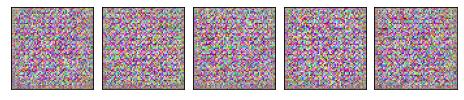

In [10]:
samples = gen.sample(5, with_grad=False)
test.assertSequenceEqual(samples.shape, (5, *x0.shape[1:]))
test.assertIsNone(samples.grad_fn)
_ = plot.tensors_as_images(samples.cpu())

samples = gen.sample(5, with_grad=True)
test.assertSequenceEqual(samples.shape, (5, *x0.shape[1:]))
test.assertIsNotNone(samples.grad_fn)

### Training
<a id=part3_7></a>

Training GANs is a bit different since we need to train two models simultaneously, each with it's own separate loss function and optimizer. We'll implement the training logic as a function that handles one batch of data
and updates both the discriminator and the generator based on it.

As mentioned above, GANs are considered hard to train. To get some ideas and tips you can see this [paper](https://arxiv.org/pdf/1606.03498.pdf), this list of ["GAN hacks"](https://github.com/soumith/ganhacks) or just do it the hard way :)

**TODO**:
1. Implement the `train_batch` function in the `hw4/gan.py` module.
2. Tweak the hyperparameters in the `part3_gan_hyperparams()` function within the `hw4/answers.py` module.

In [11]:
import torch.optim as optim
from torch.utils.data import DataLoader
from hw4.answers import part3_gan_hyperparams

torch.manual_seed(42)

# Hyperparams
hp = part3_gan_hyperparams()
batch_size = hp['batch_size']
z_dim = hp['z_dim']

# Data
dl_train = DataLoader(ds_gwb, batch_size, shuffle=True)
im_size = ds_gwb[0][0].shape

# Model
dsc = gan.Discriminator(im_size).to(device)
gen = gan.Generator(z_dim, featuremap_size=4).to(device)

# Optimizer
def create_optimizer(model_params, opt_params):
    opt_params = opt_params.copy()
    optimizer_type = opt_params['type']
    opt_params.pop('type')
    return optim.__dict__[optimizer_type](model_params, **opt_params)
dsc_optimizer = create_optimizer(dsc.parameters(), hp['discriminator_optimizer'])
gen_optimizer = create_optimizer(gen.parameters(), hp['generator_optimizer'])

# Loss
def dsc_loss_fn(y_data, y_generated):
    return gan.discriminator_loss_fn(y_data, y_generated, hp['data_label'], hp['label_noise'])

def gen_loss_fn(y_generated):
    return gan.generator_loss_fn(y_generated, hp['data_label'])

# Training
checkpoint_file = 'checkpoints/gan'
checkpoint_file_final = f'{checkpoint_file}_final'
if os.path.isfile(f'{checkpoint_file}.pt'):
    os.remove(f'{checkpoint_file}.pt')

# Show hypers
print(hp)

{'batch_size': 4, 'z_dim': 128, 'data_label': 0, 'label_noise': 0.3, 'discriminator_optimizer': {'type': 'Adam', 'lr': 0.0002, 'betas': (0.6, 0.998)}, 'generator_optimizer': {'type': 'Adam', 'lr': 0.0002, 'betas': (0.6, 0.998)}}


**TODO**:
1. Implement the `save_checkpoint` function in the `hw4.gan` module. You can decide on your own criterion regarding whether to save a checkpoint at the end of each epoch.
1. Run the following block to train. It will sample some images from your model every few epochs so you can see the progress.
2. When you're satisfied with your results, rename the checkpoints file by adding `_final`. When you run the `main.py` script to generate your submission, the final checkpoints file will be loaded instead of running training. Note that your final submission zip will not include the `checkpoints/` folder. This is OK.

--- EPOCH 1/100 ---
100%|██████████| 133/133 [00:03<00:00, 41.51it/s]
Discriminator loss: 0.2190957978591883
Generator loss:     7.581579744367671


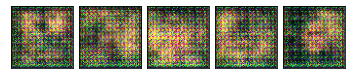

--- EPOCH 2/100 ---
100%|██████████| 133/133 [00:03<00:00, 42.60it/s]
Discriminator loss: 0.375993627046508
Generator loss:     6.456028620103248


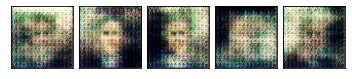

--- EPOCH 3/100 ---
100%|██████████| 133/133 [00:02<00:00, 44.74it/s]
Discriminator loss: 0.5576723007611314
Generator loss:     4.919610567558977


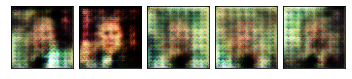

--- EPOCH 4/100 ---
100%|██████████| 133/133 [00:03<00:00, 42.75it/s]
Discriminator loss: 0.5034179173521978
Generator loss:     4.153902232646942
Saved checkpoint.


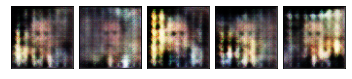

--- EPOCH 5/100 ---
100%|██████████| 133/133 [00:03<00:00, 43.97it/s]
Discriminator loss: 0.5655487754515239
Generator loss:     3.8003001688118268


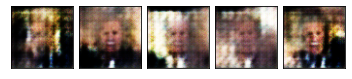

--- EPOCH 6/100 ---
100%|██████████| 133/133 [00:03<00:00, 43.74it/s]
Discriminator loss: 0.5436478135547131
Generator loss:     3.691675647308952
Saved checkpoint.


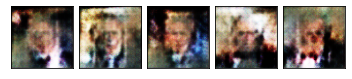

--- EPOCH 7/100 ---
100%|██████████| 133/133 [00:03<00:00, 43.29it/s]
Discriminator loss: 0.5873158931228003
Generator loss:     3.335433780698848


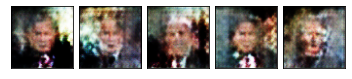

--- EPOCH 8/100 ---
100%|██████████| 133/133 [00:03<00:00, 43.95it/s]
Discriminator loss: 0.5524043802704129
Generator loss:     3.3992904854896375


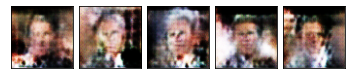

--- EPOCH 9/100 ---
100%|██████████| 133/133 [00:03<00:00, 44.18it/s]
Discriminator loss: 0.5420843870904213
Generator loss:     3.2608735888524163
Saved checkpoint.


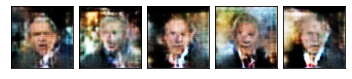

--- EPOCH 10/100 ---
100%|██████████| 133/133 [00:03<00:00, 43.66it/s]
Discriminator loss: 0.5347825932715621
Generator loss:     3.347691211485325


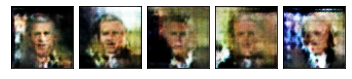

--- EPOCH 11/100 ---
100%|██████████| 133/133 [00:02<00:00, 44.47it/s]
Discriminator loss: 0.4874892494732276
Generator loss:     3.495101801434854


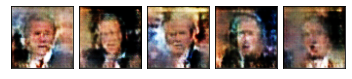

--- EPOCH 12/100 ---
100%|██████████| 133/133 [00:03<00:00, 43.88it/s]
Discriminator loss: 0.5117043137438315
Generator loss:     3.399857797568902


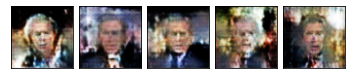

--- EPOCH 13/100 ---
100%|██████████| 133/133 [00:03<00:00, 43.39it/s]
Discriminator loss: 0.4945266580391199
Generator loss:     3.6121438508643244


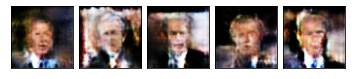

--- EPOCH 14/100 ---
100%|██████████| 133/133 [00:03<00:00, 43.24it/s]
Discriminator loss: 0.4467761474976638
Generator loss:     3.858880040340854


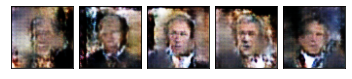

--- EPOCH 15/100 ---
100%|██████████| 133/133 [00:03<00:00, 41.06it/s]
Discriminator loss: 0.3476050636850129
Generator loss:     3.7566017315800027
Saved checkpoint.


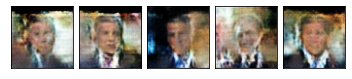

--- EPOCH 16/100 ---
100%|██████████| 133/133 [00:03<00:00, 44.25it/s]
Discriminator loss: 0.42322863705624314
Generator loss:     3.827088889322783


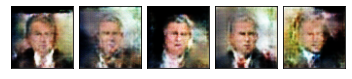

--- EPOCH 17/100 ---
100%|██████████| 133/133 [00:03<00:00, 43.11it/s]
Discriminator loss: 0.4248798497693431
Generator loss:     3.9950358894534577


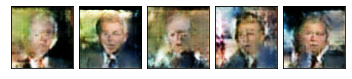

--- EPOCH 18/100 ---
100%|██████████| 133/133 [00:03<00:00, 43.47it/s]
Discriminator loss: 0.34464207850396633
Generator loss:     4.043871043319989


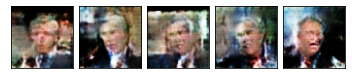

--- EPOCH 19/100 ---
100%|██████████| 133/133 [00:03<00:00, 43.89it/s]
Discriminator loss: 0.3207206403682555
Generator loss:     4.251064271855175


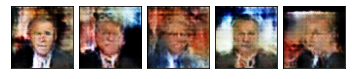

--- EPOCH 20/100 ---
100%|██████████| 133/133 [00:03<00:00, 44.33it/s]
Discriminator loss: 0.40224112644511506
Generator loss:     4.023276031913614


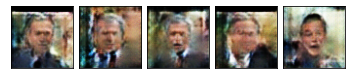

--- EPOCH 21/100 ---
100%|██████████| 133/133 [00:02<00:00, 44.36it/s]
Discriminator loss: 0.3072650340154655
Generator loss:     4.204044808122449


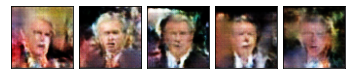

--- EPOCH 22/100 ---
100%|██████████| 133/133 [00:03<00:00, 43.51it/s]
Discriminator loss: 0.33891547269615013
Generator loss:     4.3637653929846625


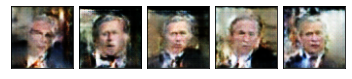

--- EPOCH 23/100 ---
100%|██████████| 133/133 [00:03<00:00, 43.92it/s]
Discriminator loss: 0.27845915401340426
Generator loss:     4.331892930475393
Saved checkpoint.


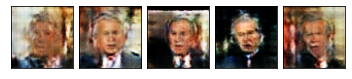

--- EPOCH 24/100 ---
100%|██████████| 133/133 [00:03<00:00, 44.18it/s]
Discriminator loss: 0.20527855306863785
Generator loss:     4.587076257942314


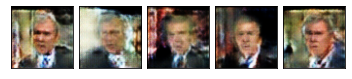

--- EPOCH 25/100 ---
100%|██████████| 133/133 [00:03<00:00, 39.64it/s]
Discriminator loss: 0.2676892869622636
Generator loss:     5.070718639775326


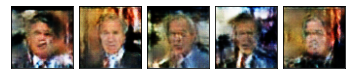

--- EPOCH 26/100 ---
100%|██████████| 133/133 [00:04<00:00, 32.34it/s]
Discriminator loss: 0.3460392777744989
Generator loss:     4.746765232623968


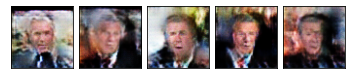

--- EPOCH 27/100 ---
100%|██████████| 133/133 [00:04<00:00, 32.72it/s]
Discriminator loss: 0.22216059471991725
Generator loss:     4.94165923989805


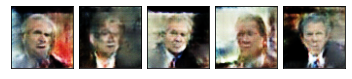

--- EPOCH 28/100 ---
100%|██████████| 133/133 [00:03<00:00, 33.51it/s]
Discriminator loss: 0.40187181521179083
Generator loss:     4.894495808092275


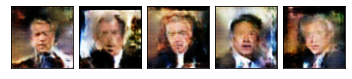

--- EPOCH 29/100 ---
100%|██████████| 133/133 [00:03<00:00, 33.43it/s]
Discriminator loss: 0.2473894180379864
Generator loss:     4.592519339314081
Saved checkpoint.


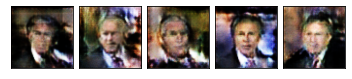

--- EPOCH 30/100 ---
100%|██████████| 133/133 [00:04<00:00, 32.88it/s]
Discriminator loss: 0.21068276927099192
Generator loss:     4.901278176702055


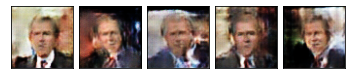

--- EPOCH 31/100 ---
100%|██████████| 133/133 [00:04<00:00, 31.17it/s]
Discriminator loss: 0.2542778781538171
Generator loss:     5.266972168047626


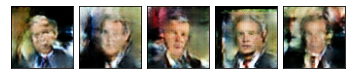

--- EPOCH 32/100 ---
100%|██████████| 133/133 [00:04<00:00, 32.30it/s]
Discriminator loss: 0.2982353298623759
Generator loss:     5.064995309464018


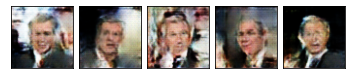

--- EPOCH 33/100 ---
100%|██████████| 133/133 [00:03<00:00, 33.39it/s]
Discriminator loss: 0.20701568949043303
Generator loss:     5.013064954513894
Saved checkpoint.


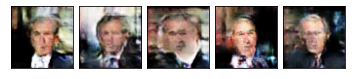

--- EPOCH 34/100 ---
100%|██████████| 133/133 [00:04<00:00, 32.77it/s]
Discriminator loss: 0.24608724107755756
Generator loss:     5.330189539973897


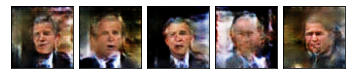

--- EPOCH 35/100 ---
100%|██████████| 133/133 [00:03<00:00, 33.43it/s]
Discriminator loss: 0.2006522306010015
Generator loss:     5.055398975099836
Saved checkpoint.


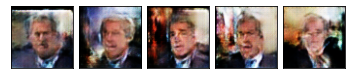

--- EPOCH 36/100 ---
100%|██████████| 133/133 [00:04<00:00, 33.22it/s]
Discriminator loss: 0.16020591050050312
Generator loss:     5.413037953520179


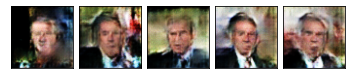

--- EPOCH 37/100 ---
100%|██████████| 133/133 [00:04<00:00, 32.61it/s]
Discriminator loss: 0.26507122318883586
Generator loss:     5.219580284634927


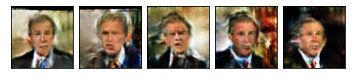

--- EPOCH 38/100 ---
100%|██████████| 133/133 [00:03<00:00, 40.67it/s]
Discriminator loss: 0.2407345438194006
Generator loss:     5.529551411481728


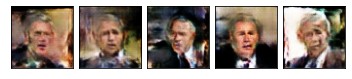

--- EPOCH 39/100 ---
100%|██████████| 133/133 [00:03<00:00, 42.86it/s]
Discriminator loss: 0.22167955882343135
Generator loss:     5.2652883184583565
Saved checkpoint.


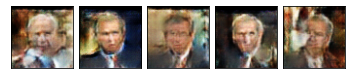

--- EPOCH 40/100 ---
100%|██████████| 133/133 [00:03<00:00, 44.23it/s]
Discriminator loss: 0.1654590068567068
Generator loss:     5.793898975042472


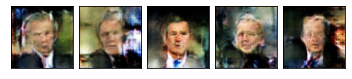

--- EPOCH 41/100 ---
100%|██████████| 133/133 [00:03<00:00, 43.94it/s]
Discriminator loss: 0.286294582643007
Generator loss:     5.647861755432043


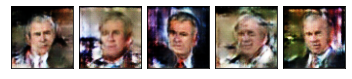

--- EPOCH 42/100 ---
100%|██████████| 133/133 [00:03<00:00, 42.27it/s]
Discriminator loss: 0.2045082821741812
Generator loss:     5.232755192240378
Saved checkpoint.


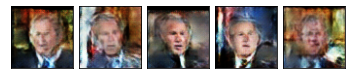

--- EPOCH 43/100 ---
100%|██████████| 133/133 [00:02<00:00, 44.38it/s]
Discriminator loss: 0.24725696923477308
Generator loss:     5.421557304554415


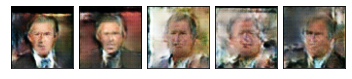

--- EPOCH 44/100 ---
100%|██████████| 133/133 [00:03<00:00, 42.23it/s]
Discriminator loss: 0.12218202471284938
Generator loss:     5.667823205316873


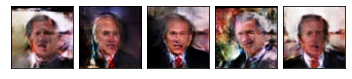

--- EPOCH 45/100 ---
100%|██████████| 133/133 [00:03<00:00, 44.08it/s]
Discriminator loss: 0.10447923886708747
Generator loss:     5.7298084425746945


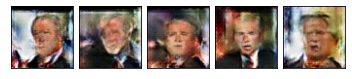

--- EPOCH 46/100 ---
100%|██████████| 133/133 [00:03<00:00, 43.71it/s]
Discriminator loss: 0.20784733884204598
Generator loss:     6.694630064910516


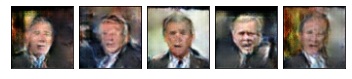

--- EPOCH 47/100 ---
100%|██████████| 133/133 [00:03<00:00, 43.24it/s]
Discriminator loss: 0.2504299006571895
Generator loss:     5.587808469184359


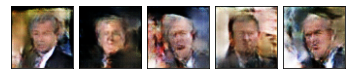

--- EPOCH 48/100 ---
100%|██████████| 133/133 [00:03<00:00, 41.48it/s]
Discriminator loss: 0.1731084656054364
Generator loss:     5.431740377182351
Saved checkpoint.


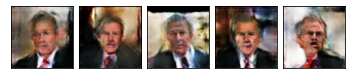

--- EPOCH 49/100 ---
100%|██████████| 133/133 [00:03<00:00, 43.02it/s]
Discriminator loss: 0.2818260106041019
Generator loss:     6.002270985366707


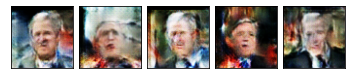

--- EPOCH 50/100 ---
100%|██████████| 133/133 [00:03<00:00, 43.88it/s]
Discriminator loss: 0.19518965844036942
Generator loss:     5.508424951617879
Saved checkpoint.


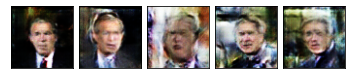

--- EPOCH 51/100 ---
100%|██████████| 133/133 [00:03<00:00, 43.52it/s]
Discriminator loss: 0.17600683271324724
Generator loss:     5.476574107220299
Saved checkpoint.


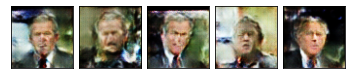

--- EPOCH 52/100 ---
100%|██████████| 133/133 [00:03<00:00, 44.04it/s]
Discriminator loss: 0.19142048839563713
Generator loss:     5.817653193509669


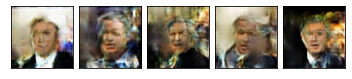

--- EPOCH 53/100 ---
100%|██████████| 133/133 [00:03<00:00, 43.60it/s]
Discriminator loss: 0.07965643715141411
Generator loss:     5.6298859961947105
Saved checkpoint.


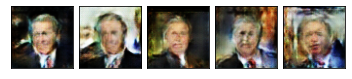

--- EPOCH 54/100 ---
100%|██████████| 133/133 [00:02<00:00, 44.38it/s]
Discriminator loss: 0.10593220356263612
Generator loss:     6.3436317730667


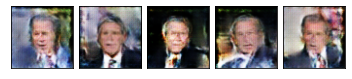

--- EPOCH 55/100 ---
100%|██████████| 133/133 [00:03<00:00, 43.88it/s]
Discriminator loss: 0.21936285462146415
Generator loss:     6.302146280618539


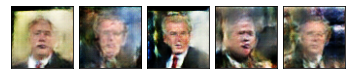

--- EPOCH 56/100 ---
100%|██████████| 133/133 [00:03<00:00, 42.98it/s]
Discriminator loss: 0.17182947577614532
Generator loss:     6.191843017599637
Saved checkpoint.


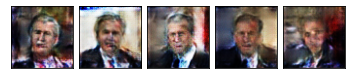

--- EPOCH 57/100 ---
100%|██████████| 133/133 [00:03<00:00, 43.98it/s]
Discriminator loss: 0.18263180324233563
Generator loss:     6.393243289531622


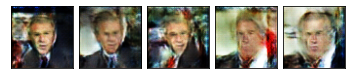

--- EPOCH 58/100 ---
100%|██████████| 133/133 [00:03<00:00, 43.69it/s]
Discriminator loss: 0.126353662124926
Generator loss:     7.208476542530203


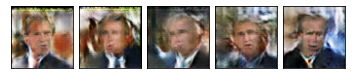

--- EPOCH 59/100 ---
100%|██████████| 133/133 [00:03<00:00, 43.61it/s]
Discriminator loss: 0.1522176316834258
Generator loss:     6.507055119464272


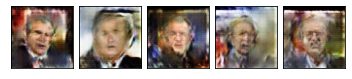

--- EPOCH 60/100 ---
100%|██████████| 133/133 [00:03<00:00, 44.05it/s]
Discriminator loss: 0.1952736633164542
Generator loss:     6.265660646266507


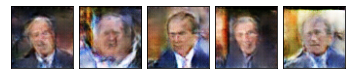

--- EPOCH 61/100 ---
100%|██████████| 133/133 [00:03<00:00, 42.65it/s]
Discriminator loss: 0.16389625418679157
Generator loss:     6.38678354786751


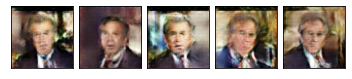

--- EPOCH 62/100 ---
100%|██████████| 133/133 [00:02<00:00, 44.73it/s]
Discriminator loss: 0.07430829205795338
Generator loss:     6.422216012065572


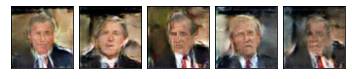

--- EPOCH 63/100 ---
100%|██████████| 133/133 [00:02<00:00, 44.64it/s]
Discriminator loss: 0.13146792318587913
Generator loss:     6.912555915072448


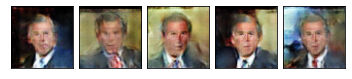

--- EPOCH 64/100 ---
100%|██████████| 133/133 [00:03<00:00, 43.16it/s]
Discriminator loss: 0.2114155925810337
Generator loss:     6.676525912786785


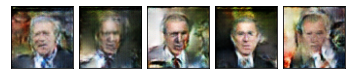

--- EPOCH 65/100 ---
100%|██████████| 133/133 [00:03<00:00, 44.17it/s]
Discriminator loss: 0.14953523476545075
Generator loss:     6.72313580387517


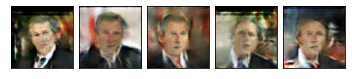

--- EPOCH 66/100 ---
100%|██████████| 133/133 [00:03<00:00, 44.16it/s]
Discriminator loss: 0.13229444429726528
Generator loss:     6.521695230240212
Saved checkpoint.


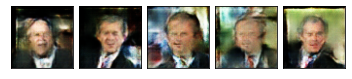

--- EPOCH 67/100 ---
100%|██████████| 133/133 [00:04<00:00, 32.27it/s]
Discriminator loss: 0.11208787313977578
Generator loss:     6.849641455743546


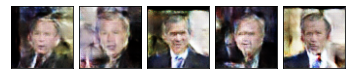

--- EPOCH 68/100 ---
100%|██████████| 133/133 [00:04<00:00, 32.97it/s]
Discriminator loss: 0.14996661894247496
Generator loss:     6.632800337067224


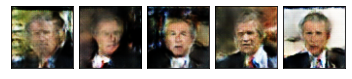

--- EPOCH 69/100 ---
100%|██████████| 133/133 [00:04<00:00, 33.17it/s]
Discriminator loss: 0.1131709978208506
Generator loss:     6.443287986561768
Saved checkpoint.


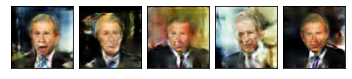

--- EPOCH 70/100 ---
100%|██████████| 133/133 [00:04<00:00, 32.79it/s]
Discriminator loss: 0.08913347511587286
Generator loss:     6.2660031130439355
Saved checkpoint.


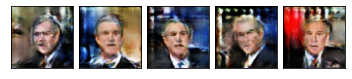

--- EPOCH 71/100 ---
100%|██████████| 133/133 [00:03<00:00, 33.47it/s]
Discriminator loss: 0.08015771848814827
Generator loss:     7.241267472281492


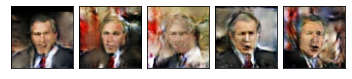

--- EPOCH 72/100 ---
100%|██████████| 133/133 [00:04<00:00, 32.73it/s]
Discriminator loss: 0.0912784420345959
Generator loss:     7.051414177830058


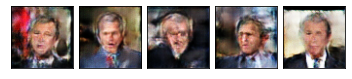

--- EPOCH 73/100 ---
100%|██████████| 133/133 [00:04<00:00, 33.06it/s]
Discriminator loss: 0.10338065411923524
Generator loss:     7.088659754373078


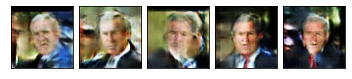

--- EPOCH 74/100 ---
100%|██████████| 133/133 [00:04<00:00, 33.17it/s]
Discriminator loss: 0.09007283709103003
Generator loss:     7.23390133219554


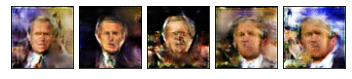

--- EPOCH 75/100 ---
100%|██████████| 133/133 [00:04<00:00, 33.18it/s]
Discriminator loss: 0.08460077601379919
Generator loss:     7.3073597976139615


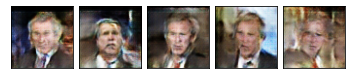

--- EPOCH 76/100 ---
100%|██████████| 133/133 [00:04<00:00, 32.80it/s]
Discriminator loss: 0.20449919858597276
Generator loss:     7.234231433474031


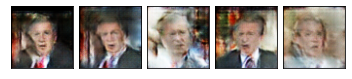

--- EPOCH 77/100 ---
100%|██████████| 133/133 [00:04<00:00, 32.86it/s]
Discriminator loss: 0.1310041579312848
Generator loss:     7.178147875276723
Saved checkpoint.


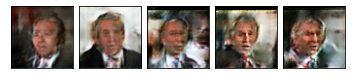

--- EPOCH 78/100 ---
100%|██████████| 133/133 [00:04<00:00, 33.25it/s]
Discriminator loss: 0.18298278242013508
Generator loss:     7.083550356384507


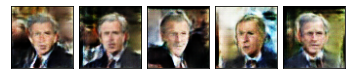

--- EPOCH 79/100 ---
100%|██████████| 133/133 [00:04<00:00, 33.08it/s]
Discriminator loss: 0.10438710157024234
Generator loss:     6.663891812016193
Saved checkpoint.


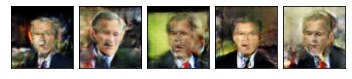

--- EPOCH 80/100 ---
100%|██████████| 133/133 [00:04<00:00, 32.90it/s]
Discriminator loss: 0.10439451145274299
Generator loss:     7.028215352753947


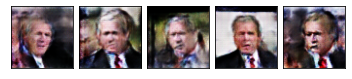

--- EPOCH 81/100 ---
100%|██████████| 133/133 [00:04<00:00, 32.46it/s]
Discriminator loss: 0.15957645609750784
Generator loss:     7.599771001733336


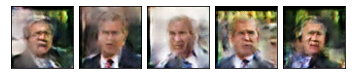

--- EPOCH 82/100 ---
100%|██████████| 133/133 [00:04<00:00, 32.82it/s]
Discriminator loss: 0.06825523168072664
Generator loss:     6.909244671800082
Saved checkpoint.


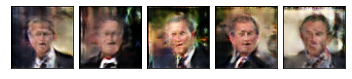

--- EPOCH 83/100 ---
100%|██████████| 133/133 [00:04<00:00, 32.81it/s]
Discriminator loss: 0.13897242895642617
Generator loss:     7.241490165990098


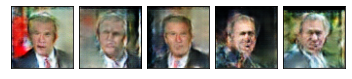

--- EPOCH 84/100 ---
100%|██████████| 133/133 [00:04<00:00, 33.10it/s]
Discriminator loss: 0.20109684482440912
Generator loss:     6.622801887361627


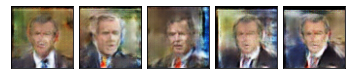

--- EPOCH 85/100 ---
100%|██████████| 133/133 [00:03<00:00, 33.49it/s]
Discriminator loss: 0.1671155015972996
Generator loss:     7.05334020288367


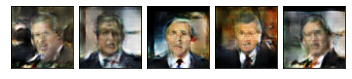

--- EPOCH 86/100 ---
100%|██████████| 133/133 [00:03<00:00, 33.45it/s]
Discriminator loss: 0.10676893160531395
Generator loss:     7.1421724226241725


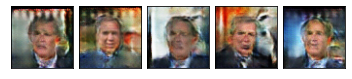

--- EPOCH 87/100 ---
100%|██████████| 133/133 [00:04<00:00, 32.98it/s]
Discriminator loss: 0.12870663656552034
Generator loss:     7.24330983305336


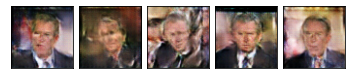

--- EPOCH 88/100 ---
100%|██████████| 133/133 [00:03<00:00, 33.26it/s]
Discriminator loss: 0.04220255173014519
Generator loss:     7.437301996058988


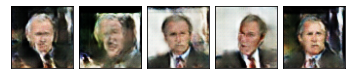

--- EPOCH 89/100 ---
100%|██████████| 133/133 [00:03<00:00, 33.30it/s]
Discriminator loss: 0.12061875534797073
Generator loss:     7.686244801471108


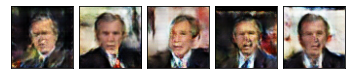

--- EPOCH 90/100 ---
100%|██████████| 133/133 [00:04<00:00, 33.10it/s]
Discriminator loss: 0.24989488953374384
Generator loss:     7.36822489688271


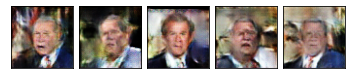

--- EPOCH 91/100 ---
100%|██████████| 133/133 [00:03<00:00, 33.43it/s]
Discriminator loss: 0.10757883038735927
Generator loss:     7.155592380609727
Saved checkpoint.


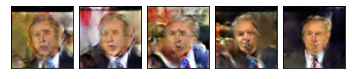

--- EPOCH 92/100 ---
100%|██████████| 133/133 [00:03<00:00, 43.48it/s]
Discriminator loss: 0.06716966836300112
Generator loss:     6.801169855254037
Saved checkpoint.


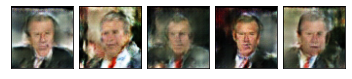

--- EPOCH 93/100 ---
100%|██████████| 133/133 [00:03<00:00, 42.84it/s]
Discriminator loss: 0.07060629375895164
Generator loss:     8.000765320053674


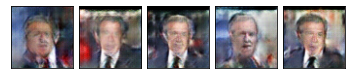

--- EPOCH 94/100 ---
100%|██████████| 133/133 [00:03<00:00, 34.51it/s]
Discriminator loss: 0.09327887127498038
Generator loss:     7.613252650526233


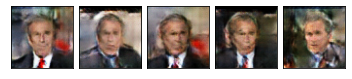

--- EPOCH 95/100 ---
100%|██████████| 133/133 [00:04<00:00, 32.98it/s]
Discriminator loss: 0.23082287295868523
Generator loss:     6.970089476359518


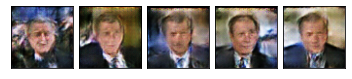

--- EPOCH 96/100 ---
100%|██████████| 133/133 [00:04<00:00, 32.50it/s]
Discriminator loss: 0.14272223642670123
Generator loss:     7.5348126691086845


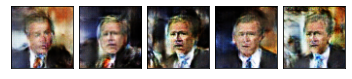

--- EPOCH 97/100 ---
100%|██████████| 133/133 [00:04<00:00, 33.04it/s]
Discriminator loss: 0.18904631808960348
Generator loss:     7.210255502982247


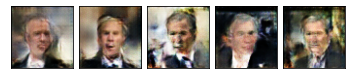

--- EPOCH 98/100 ---
100%|██████████| 133/133 [00:04<00:00, 32.93it/s]
Discriminator loss: 0.12453283137060646
Generator loss:     6.5892723879419774
Saved checkpoint.


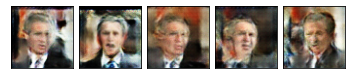

--- EPOCH 99/100 ---
100%|██████████| 133/133 [00:04<00:00, 33.13it/s]
Discriminator loss: 0.04283176160844645
Generator loss:     7.610698440021142


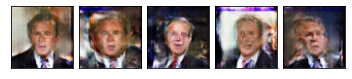

--- EPOCH 100/100 ---
100%|██████████| 133/133 [00:03<00:00, 33.31it/s]
Discriminator loss: 0.045409283691779115
Generator loss:     7.678944447883089


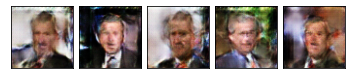

In [12]:
import IPython.display
import tqdm
from hw4.gan import train_batch, save_checkpoint

num_epochs = 100

if os.path.isfile(f'{checkpoint_file_final}.pt'):
    print(f'*** Loading final checkpoint file {checkpoint_file_final} instead of training')
    num_epochs = 0
    gen = torch.load(f'{checkpoint_file_final}.pt', map_location=device,)
    checkpoint_file = checkpoint_file_final

try:
    dsc_avg_losses, gen_avg_losses = [], []
    for epoch_idx in range(num_epochs):
        # We'll accumulate batch losses and show an average once per epoch.
        dsc_losses, gen_losses = [], []
        print(f'--- EPOCH {epoch_idx+1}/{num_epochs} ---')

        with tqdm.tqdm(total=len(dl_train.batch_sampler), file=sys.stdout) as pbar:
            for batch_idx, (x_data, _) in enumerate(dl_train):
                x_data = x_data.to(device)
                dsc_loss, gen_loss = train_batch(
                    dsc, gen,
                    dsc_loss_fn, gen_loss_fn,
                    dsc_optimizer, gen_optimizer,
                    x_data)
                dsc_losses.append(dsc_loss)
                gen_losses.append(gen_loss)
                pbar.update()

        dsc_avg_losses.append(np.mean(dsc_losses))
        gen_avg_losses.append(np.mean(gen_losses))
        print(f'Discriminator loss: {dsc_avg_losses[-1]}')
        print(f'Generator loss:     {gen_avg_losses[-1]}')
        
        if save_checkpoint(gen, dsc_avg_losses, gen_avg_losses, checkpoint_file):
            print(f'Saved checkpoint.')
            

        samples = gen.sample(5, with_grad=False)
        fig, _ = plot.tensors_as_images(samples.cpu(), figsize=(6,2))
        IPython.display.display(fig)
        plt.close(fig)
except KeyboardInterrupt as e:
    print('\n *** Training interrupted by user')

*** Images Generated from best model:


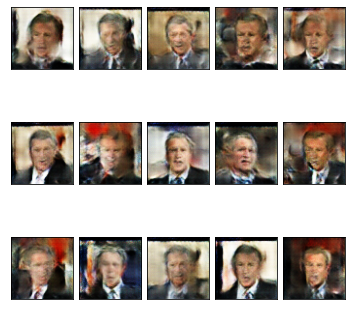

In [13]:
# Plot images from best or last model
if os.path.isfile(f'{checkpoint_file}.pt'):
    gen = torch.load(f'{checkpoint_file}.pt', map_location=device)
print('*** Images Generated from best model:')
samples = gen.sample(n=15, with_grad=False).cpu()
fig, _ = plot.tensors_as_images(samples, nrows=3, figsize=(6,6))

## Questions
<a id=part3_8></a>

**TODO** Answer the following questions. Write your answers in the appropriate variables in the module `hw4/answers.py`.

In [14]:
from cs236781.answers import display_answer
import hw4.answers as answers

### Question 1

Explain in detail why during training we sometimes need to maintain gradients when sampling from the GAN,
and other times we don't. When are they maintained and why? When are they discarded and why?

In [18]:
display_answer(answers.part3_q1)


3.
In every batch iteration we can see that the generator is used twice. In one case it is used to train the the generator we preserve the gradient in order to maintain an effective loss function the for training of  Ψγ. In the second case that it is used when training the discriminator, we are freezing the generator in  order to create images for the discriminator to be trained on. In this part, we are training only the discriminator, so we don’t care about the gradients from the generator because they are not relevant to the discriminatior training (we want to train Ψγ using the loss formula as a constant)


### Question 2

1. When training a GAN to generate images, should we decide to stop training solely based on the fact that  the Generator loss is below some threshold?
Why or why not?

2. What does it mean if the discriminator loss remains at a constant value while the generator loss decreases?

In [19]:
display_answer(answers.part3_q2)


2.1. 
We should not stop the training. 
We want to improve the discriminator and the generator together and not solely the generator,
The models are trained and tested on each other, i.e  the losses could be a result of 
a decrease in the generator loss and an increase in discriminator loss even though both have improved, with one improving more than the other it means that the Generator successfully fooled the discriminator, but maybe the discriminator is not that good yet so the generated images are not really good.
Thus the solely generative loss in this case is not an effective measurement  to decide to stop because both models affect each other.

2.2. 
The Discriminator is trying to classify between real and fake images, therefore the decrease in the generator loss is caused by better tricking the discriminator, i.e the discriminator thinks that generated images are real. 
The loss is calculated from how well the discriminator is able to identify and distinguish between the real and “fake” images. 
that the total loss $$\mathbb{E} _{\bb{x} \sim p(\bb{X}) } \log \Delta _{\bb{\delta}}(\bb{x})  \, + \,
\mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (1-\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) ))$$ 
is not really changing, the second term increases and the first decreases.  



### Question 3

Compare the results you got when generating images with the VAE to the GAN results.
What's the main difference and what's causing it?

In [20]:
display_answer(answers.part3_q3)


3.
The Generative Adversarial Network provided us with much sharper images, we can find a large variation in the expressions, backgrounds, colors and different angles of Bush. While using the Variational Autoencoder creates less sharp images, they are more smooth and smudged, they look very similar to each other and we cannot find many details as we could see in the GAN results. The images lack fine details for example, the background, facial expressions and clothing, the placement of Bush and the angle the image was taken from.

We believe that the main difference between the models comes from the difference in the final goal of the models. The GAN model's target is to trick the discriminator by thinking that a generated image is a real one. That leads to the fact that the generated images will aim to look like the real images from the dataset, including many details, different angles and expressions. While the VAE aims to create images that fits the best the probability distribution of the dataset. That leads to results that look like an average picture generator, that tries to produce pictures without noticeable difference from the real data. We can easily discriminate the results of the two models by measuring the smoothness and sharpness of the image.

